1. Here I am trying to implement the [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](http://https://arxiv.org/pdf/1609.05158.pdf) paper on medical chest X-ray images.

2. Here authors have proposed sub-pixel convolution layer which learns an array of upscaling filters to upscale the final Low Resolution feature maps into the High Resolution output. This effectively helps to eliminate bicubic filter in the Super Resolution pipeline with more complex upscaling filters specifically trained for each feature map, whilst also reducing the computational complexity of the overall Super Resolution operation. 

In [18]:
# Import all the necessary libraries

import tensorflow as tf

import os
import math
import numpy as np
import imageio

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

### Define image data generators to load and preprocess the images

In [19]:
crop_size = 512
downscale_factor = 4
input_size = crop_size // downscale_factor
batch_size = 8
root_dir = '../input/xray-normal/xray_dataset_normal/'

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 1981 files belonging to 3 classes.
Using 1585 files for training.
Found 1981 files belonging to 3 classes.
Using 396 files for validation.


### Normalize the pixels for training and validation images

In [20]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

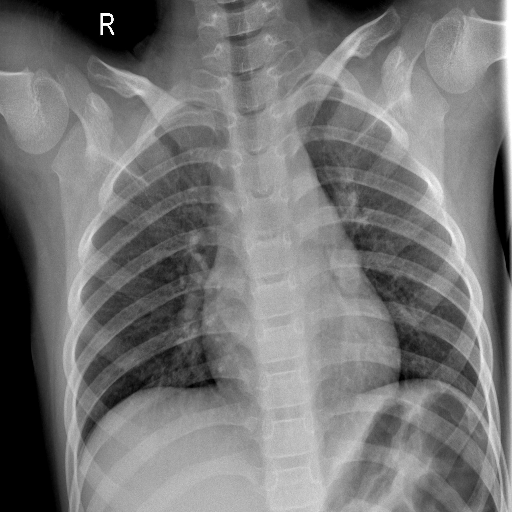

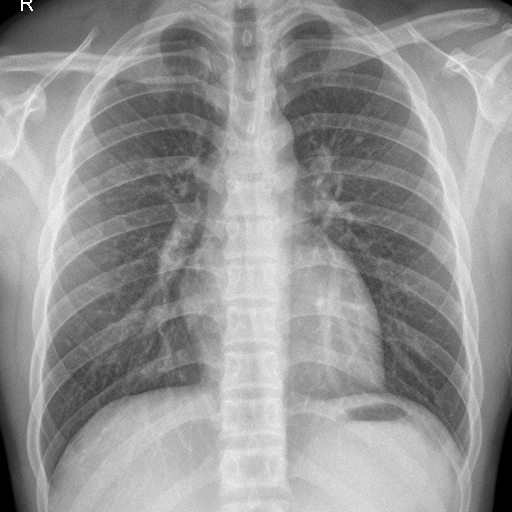

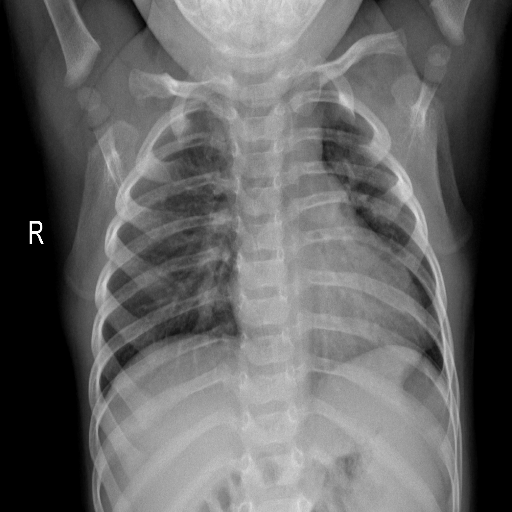

In [21]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

### Here we have prepared a dataset of test image paths that we will use for visual evaluation at the end of this example.

In [22]:
test_path_normal = os.path.join(root_dir, "test/NORMAL")

test_img_normal_paths = sorted(
    [
        os.path.join(test_path_normal, fname)
        for fname in os.listdir(test_path_normal)
        if fname.endswith(".jpeg")
    ]
)


In [23]:
len(test_img_normal_paths)

234

In [24]:
test_path_pneumonia = os.path.join(root_dir, "test/PNEUMONIA")

test_img_pneumonia_paths = sorted(
    [
        os.path.join(test_path_pneumonia, fname)
        for fname in os.listdir(test_path_pneumonia)
        if fname.endswith(".jpeg")
    ]
)

In [25]:
len(test_img_pneumonia_paths)

390

### Here we define functions to process the input images.

1. First, we convert our images from the RGB color space to the YUV colour space.
2. We take input data (low-resolution images), we crop the image, retrieve the y channel (luninance), and resize it. We only consider the luminance channel in the YUV color space because humans are more sensitive to luminance change.
3. For the target data (high-resolution images), we just crop the image and retrieve the y channel.

In [26]:
# Use TF Ops to process.
def process_input(input, input_size, downscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, downscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, downscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

### Visualize input images after processing them. And we will also look into target images

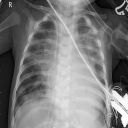

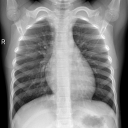

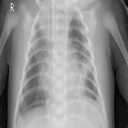

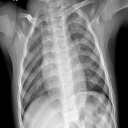

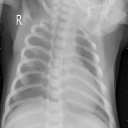

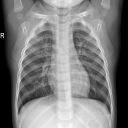

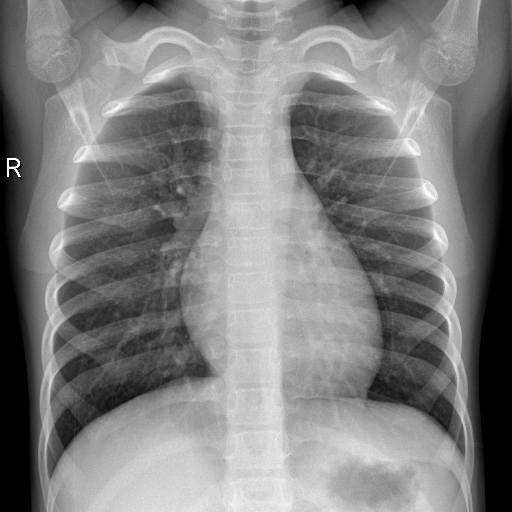

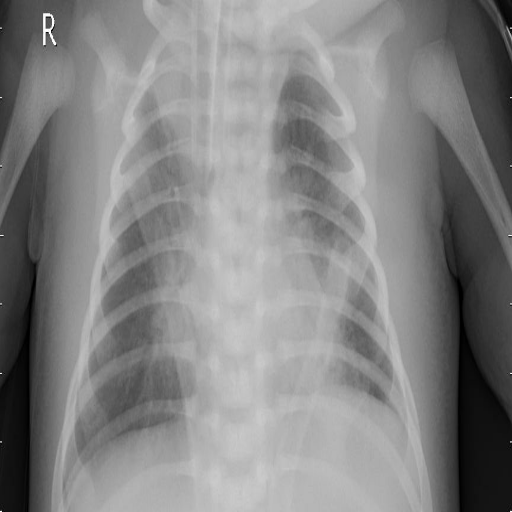

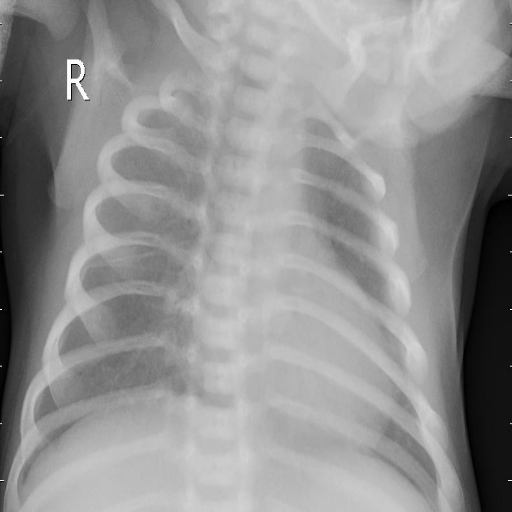

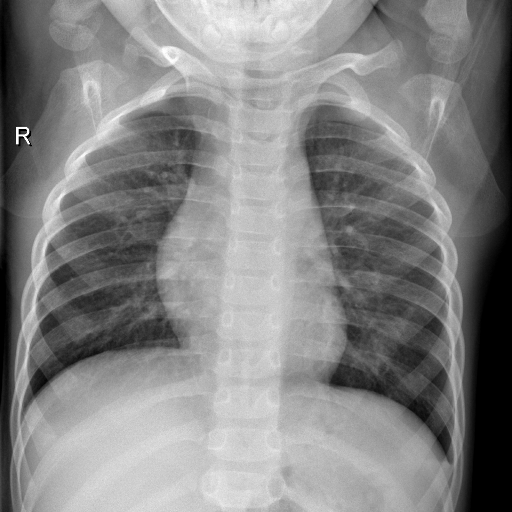

In [27]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

### Define Our CNN Model Architecture

In [28]:
def get_model(downscale_factor=4, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (downscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, downscale_factor)

    return keras.Model(inputs, outputs)

### Here we have defined some utility functions to monitor our results

1. plot_results to plot an save an image.
2. get_lowres_image to convert an image to its low-resolution version.
3. upscale_image to turn a low-resolution image to a high-resolution version reconstructed by the model. In this function, we use the y channel from the YUV color space as input to the model and then combine the output with the other channels to obtain an RGB image.

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    plt.show()


def get_lowres_image(img, downscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // downscale_factor, img.size[1] // downscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

### Here we have defined callbacks to monitor training

1. The ESPCNCallback object will compute and display the PSNR metric. 
2. This is the main metric we use to evaluate super-resolution performance.

In [30]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_normal_paths[0]), downscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [31]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(downscale_factor=downscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space_2 (TFOp (None, None, None, 1)     0         
Total params: 61,680
Trainable params: 61,680
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
199/199 - 75s - loss: 0.0100 - val_loss: 7.5589e-04
Mean PSNR for epoch: 31.18


Epoch 2/100
199/199 - 37s - loss: 6.4950e-04 - val_loss: 5.5493e-04
Mean PSNR for epoch: 32.55
Epoch 3/100
199/199 - 37s - loss: 5.5799e-04 - val_loss: 5.0010e-04
Mean PSNR for epoch: 32.92
Epoch 4/100
199/199 - 37s - loss: 5.1367e-04 - val_loss: 4.6854e-04
Mean PSNR for epoch: 33.28
Epoch 5/100
199/199 - 37s - loss: 4.8715e-04 - val_loss: 4.4586e-04
Mean PSNR for epoch: 33.45
Epoch 6/100
199/199 - 37s - loss: 4.6784e-04 - val_loss: 5.4060e-04
Mean PSNR for epoch: 32.67
Epoch 7/100
199/199 - 37s - loss: 4.6204e-04 - val_loss: 4.2527e-04
Mean PSNR for epoch: 33.69
Epoch 8/100
199/199 - 37s - loss: 4.5292e-04 - val_loss: 4.1337e-04
Mean PSNR for epoch: 33.75
Epoch 9/100
199/199 - 37s - loss: 4.5404e-04 - val_loss: 4.0704e-04
Mean PSNR for epoch: 33.90
Epoch 10/100
199/199 - 38s - loss: 4.2886e-04 - val_loss: 4.0367e-04
Mean PSNR for epoch: 33.85
Epoch 11/100
199/199 - 38s - loss: 4.3175e-04 - val_loss: 4.5759e-04
Mean PSNR for epoch: 33.25
Epoch 12/100
199/199 - 39s - loss: 4.3727e-04 - 

Epoch 22/100
199/199 - 37s - loss: 4.1172e-04 - val_loss: 3.6307e-04
Mean PSNR for epoch: 34.37
Epoch 23/100
199/199 - 37s - loss: 3.8327e-04 - val_loss: 3.6006e-04
Mean PSNR for epoch: 34.43
Epoch 24/100
199/199 - 37s - loss: 3.8374e-04 - val_loss: 3.9674e-04
Mean PSNR for epoch: 33.95
Epoch 25/100
199/199 - 37s - loss: 3.8861e-04 - val_loss: 3.6822e-04
Mean PSNR for epoch: 34.28
Epoch 26/100
199/199 - 37s - loss: 3.8113e-04 - val_loss: 5.8846e-04
Mean PSNR for epoch: 32.26
Epoch 27/100
199/199 - 37s - loss: 3.8327e-04 - val_loss: 3.6696e-04
Mean PSNR for epoch: 34.36
Epoch 28/100
199/199 - 37s - loss: 3.8213e-04 - val_loss: 4.4425e-04
Mean PSNR for epoch: 33.42
Epoch 29/100
199/199 - 38s - loss: 3.7020e-04 - val_loss: 3.7027e-04
Mean PSNR for epoch: 34.23
Epoch 30/100
199/199 - 38s - loss: 4.0137e-04 - val_loss: 3.5236e-04
Mean PSNR for epoch: 34.48
Epoch 31/100
199/199 - 37s - loss: 3.5797e-04 - val_loss: 3.8406e-04
Mean PSNR for epoch: 34.18
Epoch 32/100
199/199 - 37s - loss: 3.648

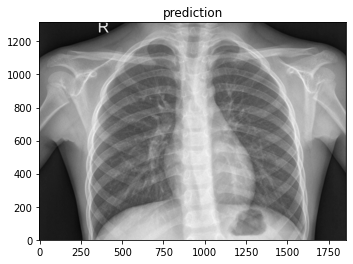

Epoch 42/100
199/199 - 38s - loss: 3.4402e-04 - val_loss: 3.3757e-04
Mean PSNR for epoch: 34.63
Epoch 43/100
199/199 - 38s - loss: 9.5246e-04 - val_loss: 4.4360e-04
Mean PSNR for epoch: 33.57
Epoch 44/100
199/199 - 38s - loss: 4.2809e-04 - val_loss: 3.9842e-04
Mean PSNR for epoch: 33.92
Epoch 45/100
199/199 - 38s - loss: 3.9953e-04 - val_loss: 3.8107e-04
Mean PSNR for epoch: 34.14
Epoch 46/100
199/199 - 38s - loss: 3.8966e-04 - val_loss: 3.7265e-04
Mean PSNR for epoch: 34.15
Epoch 47/100
199/199 - 38s - loss: 3.8064e-04 - val_loss: 3.6526e-04
Mean PSNR for epoch: 34.38
Epoch 48/100
199/199 - 38s - loss: 3.7655e-04 - val_loss: 3.6408e-04
Mean PSNR for epoch: 34.28
Epoch 49/100
199/199 - 38s - loss: 3.8851e-04 - val_loss: 3.6044e-04
Mean PSNR for epoch: 34.46
Epoch 50/100
199/199 - 38s - loss: 3.6401e-04 - val_loss: 3.5335e-04
Mean PSNR for epoch: 34.40
Epoch 51/100
199/199 - 39s - loss: 3.6456e-04 - val_loss: 3.5141e-04
Mean PSNR for epoch: 34.51
Epoch 52/100
199/199 - 38s - loss: 3.674

In [32]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

### Now we run the model prediction and plot the results

In [33]:
# os.mkdir('./HR_NORMAL_imgs')
# os.mkdir('./SR_NORMAL_imgs')

In [34]:
# os.mkdir('./HR_PNEUMONIA_imgs')
# os.mkdir('./SR_PNEUMONIA_imgs')

## Testing On Normal Images

PSNR of low resolution image and high resolution image is 37.7831
PSNR of predict and high resolution is 37.9573


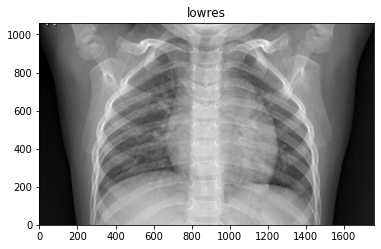

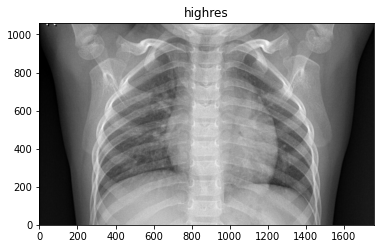

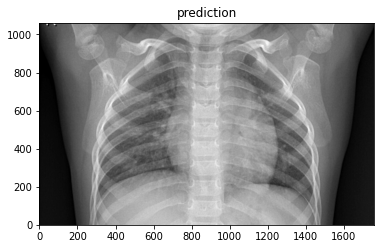

PSNR of low resolution image and high resolution image is 36.3927
PSNR of predict and high resolution is 36.5355


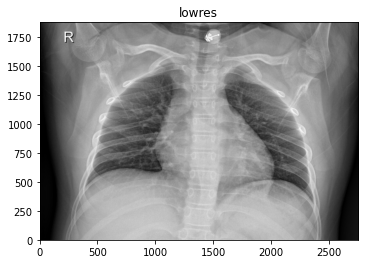

PSNR of low resolution image and high resolution image is 38.5434
PSNR of predict and high resolution is 38.8683


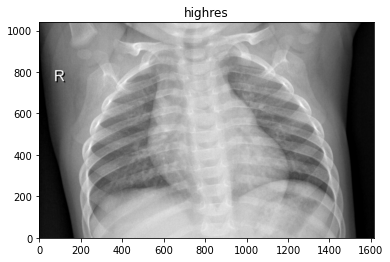

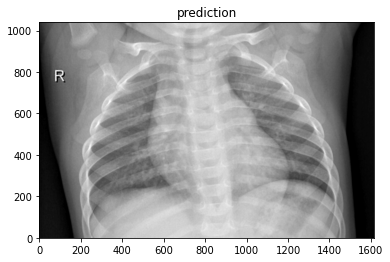

PSNR of low resolution image and high resolution image is 39.2246
PSNR of predict and high resolution is 39.5628


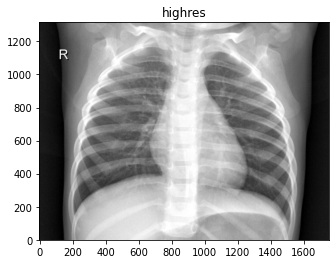

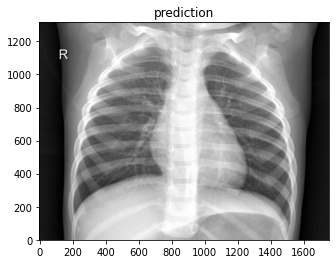

PSNR of low resolution image and high resolution image is 39.6075
PSNR of predict and high resolution is 40.2353


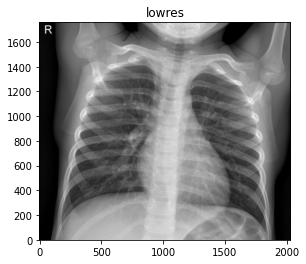

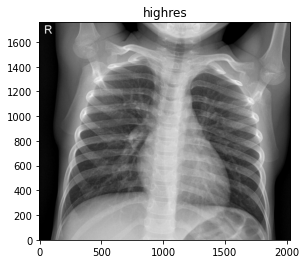

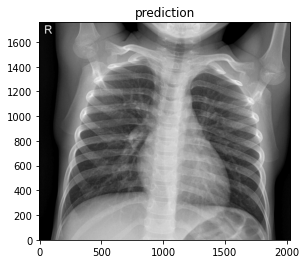

PSNR of low resolution image and high resolution image is 40.6891
PSNR of predict and high resolution is 40.5989


PSNR of low resolution image and high resolution image is 38.6133
PSNR of predict and high resolution is 39.0165


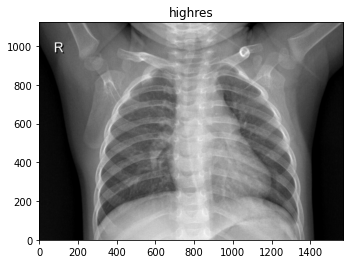

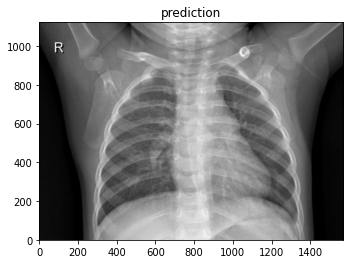

PSNR of low resolution image and high resolution image is 39.3669
PSNR of predict and high resolution is 39.6005


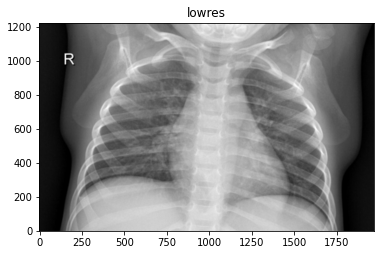

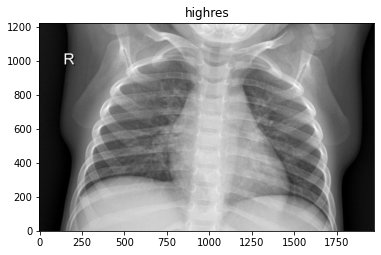

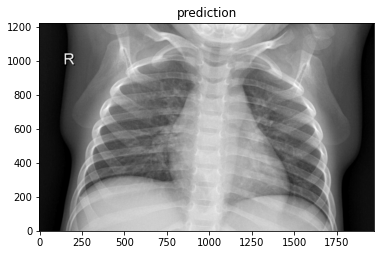

PSNR of low resolution image and high resolution image is 41.2988
PSNR of predict and high resolution is 41.0104


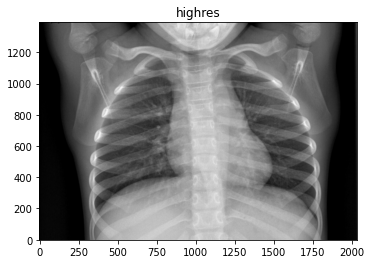

PSNR of low resolution image and high resolution image is 38.6977
PSNR of predict and high resolution is 38.9668


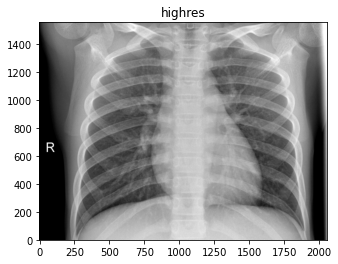

Avg. PSNR of lowres images is 39.0217
Avg. PSNR of reconstructions is 39.2352


In [45]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_normal_paths[35:45]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, downscale_factor)
    w = lowres_input.size[0] * downscale_factor
    h = lowres_input.size[1] * downscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    
#     imageio.imwrite('./SR_NORMAL_imgs/SR_'+str(index+1)+'.jpeg', np.asarray(prediction, dtype=float))
#     imageio.imwrite('./HR_NORMAL_imgs/HR_'+str(index+1)+'.jpeg', np.asarray(highres_img, dtype=float))
    
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

## Testing On Pneumonia Images

PSNR of low resolution image and high resolution image is 34.9074
PSNR of predict and high resolution is 35.5160


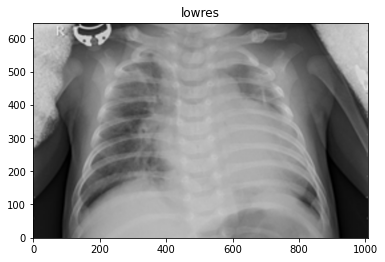

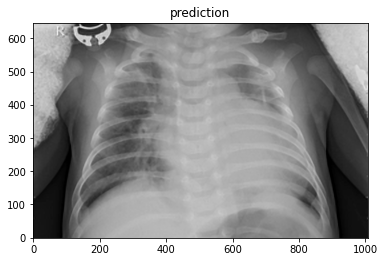

PSNR of low resolution image and high resolution image is 36.3486
PSNR of predict and high resolution is 37.6981


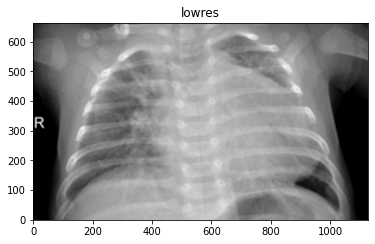

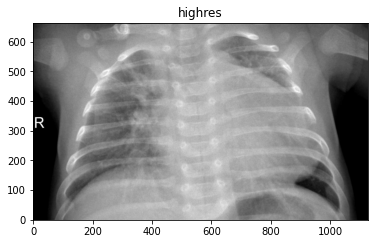

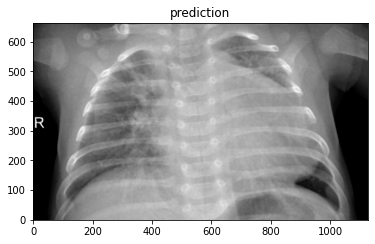

PSNR of low resolution image and high resolution image is 35.6399
PSNR of predict and high resolution is 36.4984


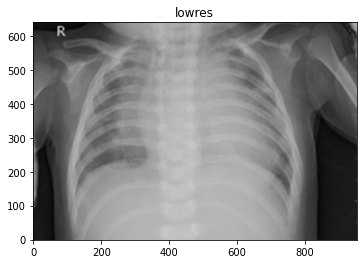

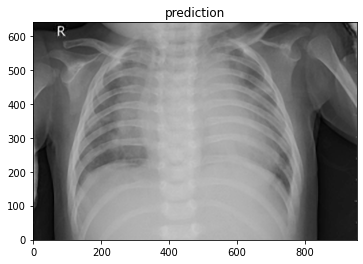

PSNR of low resolution image and high resolution image is 34.4049
PSNR of predict and high resolution is 35.2716


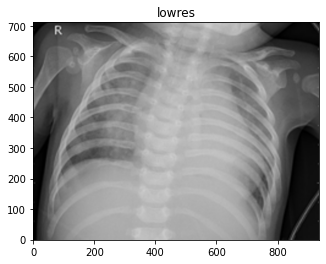

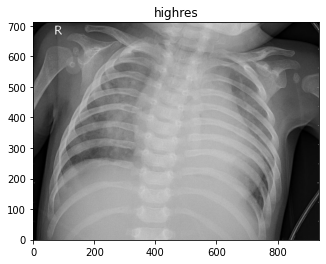

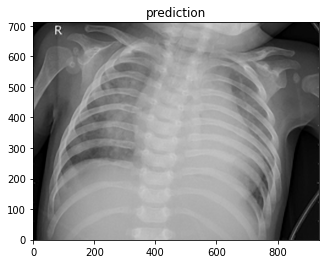

PSNR of low resolution image and high resolution image is 35.1050
PSNR of predict and high resolution is 35.5998


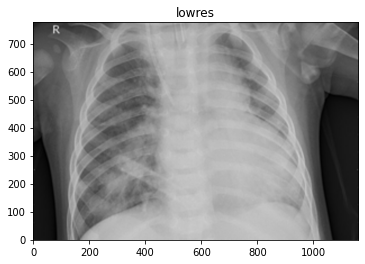

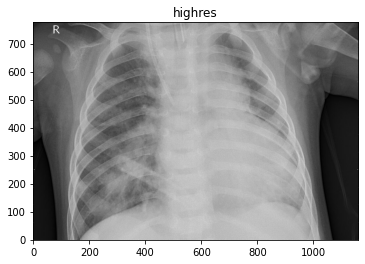

PSNR of low resolution image and high resolution image is 37.2487
PSNR of predict and high resolution is 37.7357


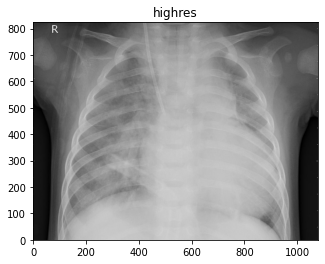

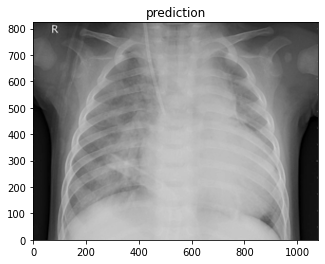

PSNR of low resolution image and high resolution image is 36.2875
PSNR of predict and high resolution is 36.6726


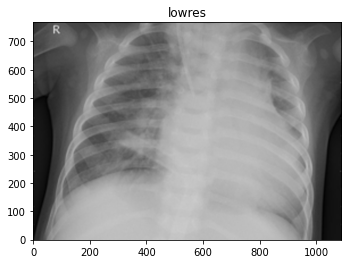

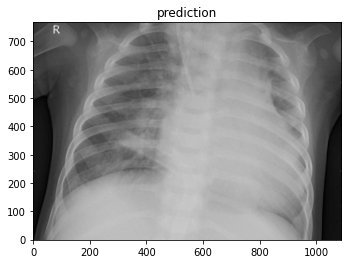

PSNR of low resolution image and high resolution image is 37.6033
PSNR of predict and high resolution is 37.9906


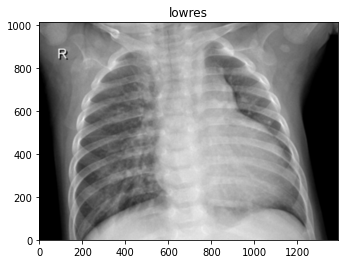

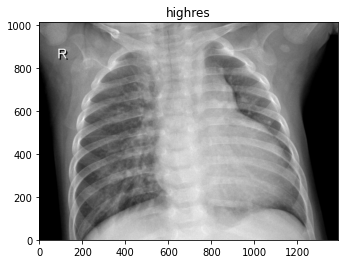

PSNR of low resolution image and high resolution image is 36.1300
PSNR of predict and high resolution is 36.4364


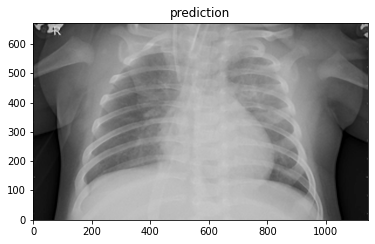

PSNR of low resolution image and high resolution image is 36.1997
PSNR of predict and high resolution is 36.8275


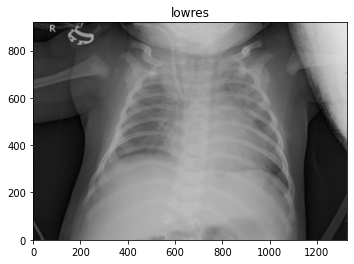

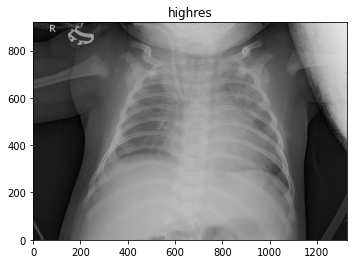

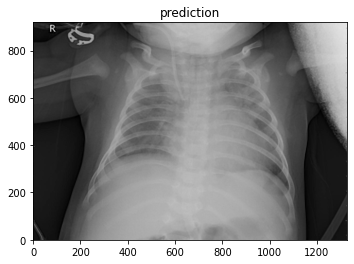

Avg. PSNR of lowres images is 35.9875
Avg. PSNR of reconstructions is 36.6247


In [47]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_pneumonia_paths[35:45]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, downscale_factor)
    w = lowres_input.size[0] * downscale_factor
    h = lowres_input.size[1] * downscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    
#     imageio.imwrite('./SR_PNEUMONIA_imgs/SR_'+str(index+1)+'.jpeg', np.asarray(prediction, dtype=float))
#     imageio.imwrite('./HR_PNEUMONIA_imgs/HR_'+str(index+1)+'.jpeg', np.asarray(highres_img, dtype=float))

    
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [41]:
# %%!

# zip -r HR_NORMAL_imgs.zip ./HR_NORMAL_imgs

In [42]:
# %%!

# zip -r SR_NORMAL_imgs.zip ./SR_NORMAL_imgs

In [43]:
# %%!

# zip -r HR_PNEUMONIA_imgs.zip ./HR_PNEUMONIA_imgs

In [44]:
# %%!

# zip -r SR_PNEUMONIA_imgs.zip ./SR_PNEUMONIA_imgs